# Motion analysis

This is a detailed tutorial for automated identification of lines of interest (LOIs), and sarcomere motion tracking and analysis using the SarcAsM Python API. 

A detailed documentation of all functions can be found in [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion). 

For each LOI, results are stored in the dictionary `mot_obj.loi_data` and a detailed list of all functional features is [available here](../motion_features.rst).

Download the Jupyter notebook [here](https://github.com/danihae/SarcAsM/tree/main/docs/notebooks).

Below the analysis of a high-speed confocal movie (67 frames/second) of a spontaneously beating hiPSC-derived cardiomyocyte is described. 


In [1]:
# import package
from sarcasm import *
import matplotlib.pyplot as plt

## Automated detection of lines of interest (LOIs) for motion tracking
For automated LOI detection, SarcAsM first detects Z-bands using deep learning and analyzes the sarcomere structure and then, on this basis, identifies regions with well-ordered sarcomeres. It is mandatory to specify the `frametime`, if not in file metadata. Details on structural analysis see [API reference](../autoapi/sarcasm/structure/index.html#sarcasm.structure.Structure) and [tutorial on structural analysis](tutorial_structure_analysis).
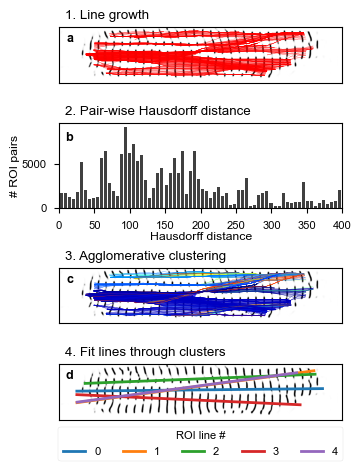

In [2]:
# enter path of tif-file, can be both single image and movie
filepath = '../../test_data/high_speed_single_ACTN2-citrine_CM/30kPa.tif'

# initialize Structure object
sarc = Structure(filepath)

In [5]:
# detection of sarcomere features using deep learning
sarc.detect_sarcomeres(frames=0, max_patch_size=(256, 1024))  # just for 1st frame to identify LOIs

# segmentation of Z-bands using time-consistent 3D U-Net
sarc.detect_z_bands_fast_movie(max_patch_size=(32, 210, 1024))

# analysis of sarcomere length and orientation (only single frame)
sarc.analyze_sarcomere_vectors(frames=0)


Predicting sarcomeres ...


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]



Predicting sarcomere z-bands ...


100%|██████████| 56/56 [03:07<00:00,  3.35s/it]



Starting sarcomere length and orientation analysis...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


After the analysis of sarcomere lengths and orientations, SarcAsM automatically detects ROI lines by `Structure.detect_lois()`. Function parameters are described in docstring and in [API reference](../autoapi/sarcasm/structure/index.html#sarcasm.structure.Structure.detect_lois).

In [16]:
sarc.delete_lois()

In [17]:
# detect 2 LOIs
sarc.detect_lois(n_lois=2, persistence=6, mode='fit_straight_line')

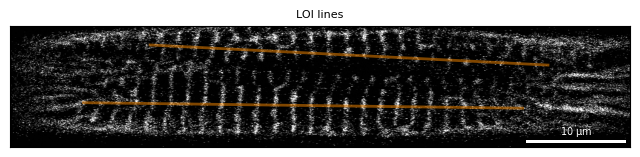

In [18]:
# plot automatically detected LOIs
fig, ax = plt.subplots(figsize=(8, 3))

# plot image
Plots.plot_image(ax, sarc, show_loi=True, title='LOI lines')

## Initialization of Motion object for LOI

For tracking and analyzing individual and average sarcomere motion, a new `Motion` object is created for each LOI. Use `Utils.get_lois_of_file` or `sarc_obj.get_list_lois` to get a list of all LOIs. Details see docstrings and [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion).


In [19]:
# get list of all LOIs of a SarcAsM object 
lois = sarc.get_list_lois()

# select LOI from list and initialize Motion object
i = 0  # index of LOI
file, roi = lois[i]
mot_obj = Motion(file, roi)

LOI not yet analyzed.
LOI data saved!


## Full analysis of LOI with default parameters
For full tracking and analysis of sarcomere motion in LOI in one step with default parameters, the function `mot_obj.full_analysis_loi` can be used. A detailed step-by-step guide can be found in section below.

In [20]:
# full analysis of LOI
mot_obj.full_analysis_loi()

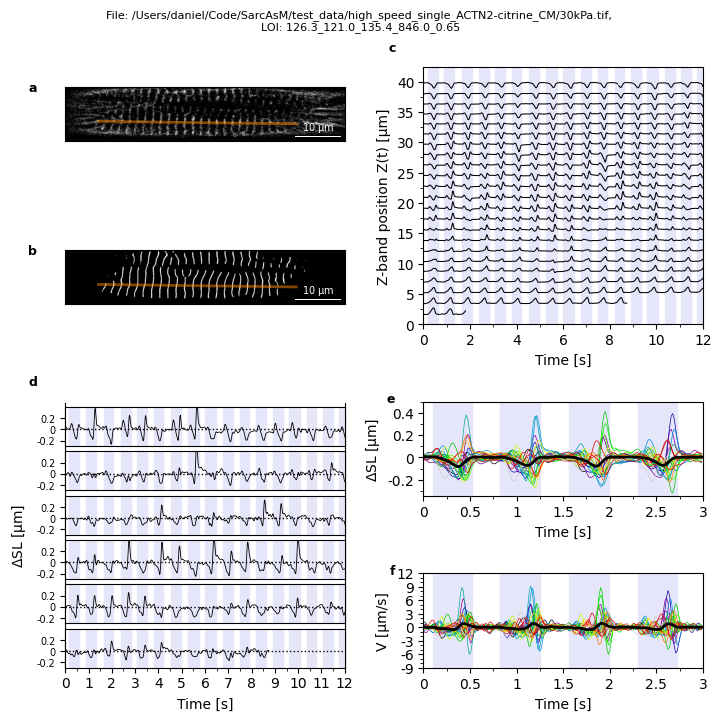

In [21]:
# create summary figure of LOI
Plots.plot_loi_summary_motion(mot_obj)

## Step-by-step guide

### Detection of Z-band positions
Detection of Z-band positions from intensity profiles for each frame obtained from Z-bands detected by U-Net or 3D U-Net. All function parameters see docstring or [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.detect_peaks).

In [22]:
mot_obj.detekt_peaks()

LOI data saved!


### Tracking of Z-bands 
Tracking of individual Z-bands through movie using Crocker-Grier algorithm. All function parameters see docstring or [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.track_z_bands).

In [23]:
mot_obj.track_z_bands()

### Detection and analysis of contraction intervals
Prediction of contraction intervals using neural network ContractionNet, and analysis of beating rate, etc. All function parameters see docstring or [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.detect_analyze_contractions). 

A detailed list of all analyzed features can be found [here](motion_features).

In [24]:
mot_obj.detect_analyze_contractions()

LOI data saved!


### Calculation of sarcomere trajectories
Based on the contraction intervals, the resting length and sarcomere length change and velocity of each individual sarcomere and the average are calculated. All function parameters see docstring or [API reference](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.get_trajectories).


In [25]:
mot_obj.get_trajectories()

LOI data saved!


### Analysis of individual and average sarcomere trajectories
Time-series analyses of individual and average sarcomere motion. A detailed list of analyzed features can be found [here](motion_features).

In [26]:
mot_obj.analyze_trajectories()

LOI data saved!
LOI data saved!


### Further functional analyses

Below is a list of analysis described in our paper "Stochastic tug-of-war among sarcomere mediates cardiomyocyte response to environmental stiffness", [DOI:10.1101/2024.05.28.596183](https://doi.org/10.1101/2024.05.28.596183).

- `mot_obj.analyze_popping`, details [here](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.analyze_popping): analysis of sarcomere popping events, rapid extensions of individual sarcomeres far beyond resting length.
- `mot_obj.analyze_correlations`, details [here](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.analyze_correlations): correlation of individual sarcomere motion to identify static or stochastic heterogeneity.
- `mot_obj.analyze_oscillations`, details [here](../autoapi/sarcasm/motion/index.html#sarcasm.motion.Motion.analyze_oscillations): analysis of high-frequency oscillatory contractions of individual sarcomeres using wavelet analysis. 